# 1. Setup and Create Custom Dataset

In [2]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import json
import torch.optim as optim
from torch.utils.data import DataLoader

class CustomDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform

        self.images = sorted(os.listdir(image_folder))
        self.labels = sorted(file for file in os.listdir(label_folder) if file.endswith('.json'))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_folder, self.images[idx])

        # Get the corresponding label file in the label folder
        label_file = self.labels[idx]
        label_path = os.path.join(self.label_folder, label_file)

        image = Image.open(img_path).convert("RGB")

        # Open and read the content of the label file
        with open(label_path, 'r') as f:
            # Load JSON content from the label file
            label_data = json.load(f)

        # Convert label data to tensor
        # Assuming your label_data contains 'class' and 'bboxes'
        label_tensor = torch.tensor([label_data['class']] + label_data['bbox'], dtype=torch.float32)

        # Apply transformations
        if self.transform:
            image = self.transform(image)

        return image, label_tensor

# Define your transformation
transform = transforms.Compose([
    transforms.Resize((120, 120)),
    transforms.ToTensor()
])

train_dataset = CustomDataset(image_folder='aug_data/train/images', label_folder='aug_data/train/labels', transform=transform)
val_dataset = CustomDataset(image_folder='aug_data/val/images', label_folder='aug_data/val/labels/', transform=transform)

# 2- Create the CNN using Batch-Norm and Max-Pooling

In [3]:
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.batch_norm1 = nn.BatchNorm2d(16)
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.batch_norm2 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.batch_norm3 = nn.BatchNorm2d(64)
        self.pool3 = nn.MaxPool2d(2, 2)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.batch_norm4 = nn.BatchNorm2d(128)
        self.pool4 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, 256)  
        self.fc3 = nn.Linear(256, 5)  # Assuming 6 parameters for bounding box + class

    def forward(self, x):
        x = self.pool1(self.batch_norm1(nn.functional.relu(self.conv1(x))))
        x = self.pool2(self.batch_norm2(nn.functional.relu(self.conv2(x))))
        x = self.pool3(self.batch_norm3(nn.functional.relu(self.conv3(x))))
        x = self.pool4(self.batch_norm4(nn.functional.relu(self.conv4(x))))

        x = x.view(-1, 128 * 7 * 7)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))  
        x = self.fc3(x)

        return x

model = SimpleCNN()

# 3- Train the model

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


def train(model, train_loader, val_loader, num_epochs, learning_rate):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item()
            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            _, labels_max = torch.max(labels.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels_max).sum().item()

        train_accuracy = correct_train / total_train

        # Validation
        model.eval()
        epoch_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss = criterion(outputs, labels)
                epoch_val_loss += val_loss.item()
                # Calculate accuracy
                _, predicted = torch.max(outputs.data, 1)
                _, labels_max = torch.max(labels.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels_max).sum().item()

        val_accuracy = correct_val / total_val

        # Average loss over all batches in an epoch
        epoch_train_loss /= len(train_loader)
        epoch_val_loss /= len(val_loader)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}, Train Accuracy: {train_accuracy}, Validation Accuracy: {val_accuracy}')

        # Save losses and accuracies for plotting
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)

    return train_losses, val_losses, train_accuracies, val_accuracies
    
# Train the model
train_losses, val_losses, train_accuracies, val_accuracies = train(model, train_loader, val_loader, num_epochs=20, learning_rate=0.0004)

# Save the model
model_path = 'Models/model3_1_CNN.pth'
torch.save(model.state_dict(), model_path)


Epoch 1/20, Train Loss: 0.07375233316173156, Validation Loss: 0.1156344615987369, Train Accuracy: 0.810752688172043, Validation Accuracy: 1.0
Epoch 2/20, Train Loss: 0.020464847392092148, Validation Loss: 0.05819348006376198, Train Accuracy: 0.874731182795699, Validation Accuracy: 0.9023809523809524
Epoch 3/20, Train Loss: 0.014519095824410518, Validation Loss: 0.029349076694675853, Train Accuracy: 0.874731182795699, Validation Accuracy: 0.9119047619047619
Epoch 4/20, Train Loss: 0.01350056945035855, Validation Loss: 0.02970487597797598, Train Accuracy: 0.860752688172043, Validation Accuracy: 0.9071428571428571
Epoch 5/20, Train Loss: 0.009963382904728254, Validation Loss: 0.026944530861718313, Train Accuracy: 0.8666666666666667, Validation Accuracy: 0.9595238095238096
Epoch 6/20, Train Loss: 0.008498982565167049, Validation Loss: 0.02276428882032633, Train Accuracy: 0.8650537634408603, Validation Accuracy: 0.9023809523809524
Epoch 7/20, Train Loss: 0.007630488229915499, Validation Los

# 4- Plot the Training Loss x Validation Loss and Model Accuracy

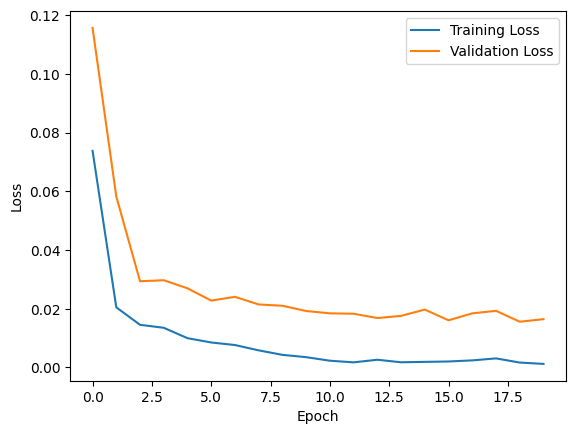

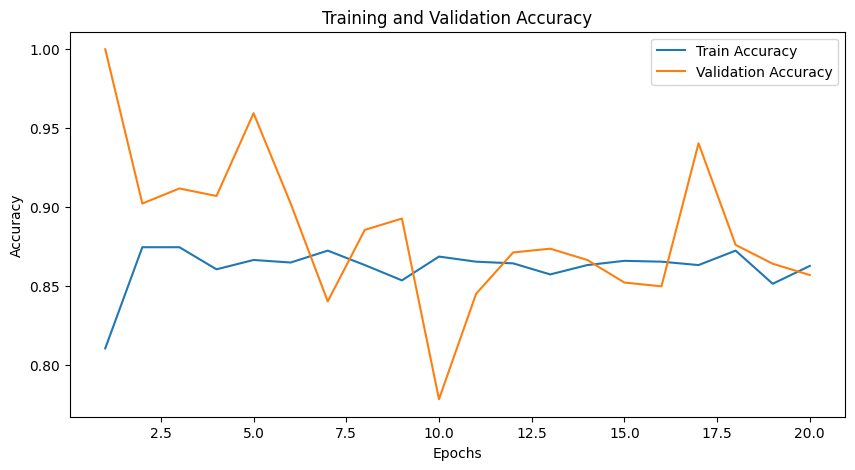

In [5]:
import matplotlib.pyplot as plt
# Plotting the val loss and train loss
def plot_loss(train_losses, val_losses):
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses)


# Plotting the accuracy
plt.figure(figsize=(10,5))
plt.plot(range(1, 21), train_accuracies, label='Train Accuracy')
plt.plot(range(1, 21), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

In [8]:
import cv2
import torch
import numpy as np
from torchvision import transforms
from PIL import Image

# Load the trained model
model = SimpleCNN()
model.load_state_dict(torch.load('Models/model3_1_CNN.pth'))
model.eval()

def detect_face(frame, model):
    # Preprocess the frame
    img = cv2.resize(frame, (120, 120))
    img = Image.fromarray(img)  # Convert numpy array to PIL Image
    transform = transforms.Compose([
        transforms.ToTensor(),
        # Add any other necessary transformations
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension

    # Run the model
    with torch.no_grad():
        output = model(img)

    print(output[0,0])
        

    # Post-process the output (assuming bounding box coordinates and class)
    # Extract class and bounding box coordinates from the output tensor
    pred_class = int(output[0, 0] > 0.5)
    bbox = list(map(float, output[0, 1:].tolist()))
    print(pred_class)
    

    # Draw bounding box only if the predicted class is 1
    if pred_class == 1:
        print(f"Class: {pred_class}, Bbox: {bbox}")
    
        bbox = [int(coord * frame.shape[1]) for coord in bbox]  # Scale coordinates

        cv2.rectangle(frame, (bbox[0], bbox[1]), (bbox[2], bbox[3]), (0, 255, 0), 2)

    return frame

# Open a webcam
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # Detect face
    frame = detect_face(frame, model)

    # Display the resulting frame
    cv2.imshow('Face Detection', frame)

    if cv2.waitKey(1) & 0xFF == 27:  # Press 'Esc' to exit
        break

# Release the capture
cap.release()
cv2.destroyAllWindows()

tensor(0.8906)
1
Class: 1, Bbox: [0.09000305831432343, 0.10173209011554718, 0.36317339539527893, 0.5438680648803711]
tensor(0.6882)
1
Class: 1, Bbox: [0.05687426030635834, 0.32441413402557373, 0.3855360448360443, 0.6059474945068359]
tensor(0.7086)
1
Class: 1, Bbox: [0.05756340175867081, 0.3248944580554962, 0.3880990445613861, 0.6323562860488892]
tensor(0.7330)
1
Class: 1, Bbox: [0.04624821990728378, 0.3284049928188324, 0.3930217921733856, 0.6406043767929077]
tensor(0.7231)
1
Class: 1, Bbox: [0.05882186442613602, 0.3274162709712982, 0.39488571882247925, 0.6261646747589111]
tensor(0.7260)
1
Class: 1, Bbox: [0.05500490218400955, 0.32062235474586487, 0.38691017031669617, 0.6233503818511963]
tensor(0.7177)
1
Class: 1, Bbox: [0.036666907370090485, 0.31224632263183594, 0.3888874053955078, 0.6332472562789917]
tensor(0.7307)
1
Class: 1, Bbox: [0.046473585069179535, 0.3386784493923187, 0.39309975504875183, 0.6465834379196167]
tensor(0.7411)
1
Class: 1, Bbox: [0.05761890858411789, 0.3545073568820